# Predição de notas dos discos a partir de críticas da Pitchfork

Pitchfork é um dos maiores sites de resenhas musicais do mundo, publicando diariamente críticas de discos e músicas. Em todas essas críticas, o site disponibiliza também uma nota entre 0 e 10 à obra, geralmente relacionada ao conteúdo dessa avaliação. Considerando isso, este trabalho tem como objetivo prever qual será a nota dada a um disco utilizando informações do texto da crítica, metadados do disco avaliado, e informações do seu autor. 

Os dados utilizados para a predição foram obtidos através de scrapping no site da Pitchfork, utilizando as bibliotecas `requests` e `BeautifulSoup`, e seu código é apresentado no script `scrape_reviews.py`. Foram carregadas 500 páginas do site, com 12 discos cada uma. Foram descartados discos que não incluíam informações de gênero, e houveram também páginas que não carregaram corretamente, atingindo um total de 5661 críticas no conjunto de dados final.

In [9]:
import pandas as pd

reviews = pd.read_csv("reviews-albums.csv", sep=";")
reviews.head()

,artist,title,text,genre,year,author,score
0,Xenia Rubinos,Una Rosa,Best new music The singer-songwriter’s latest...,Rock,2021,Contributor,8.4
1,Lana Del Rey,Blue Banisters,Lana Del Rey’s second album of the year is a ...,Pop/R&B,2021,Associate Editor,7.7
2,Black Marble,Fast Idol,Chris Stewart continues his decade-long quest...,Rock,2021,Contributor,6.8
3,UNIIQU3,Heartbeats,The breakout star of the regional subgenre kn...,Electronic,2021,Contributor,7.8
4,Dos Santos,City of Mirrors,Approaching the rich Latinx musical tradition...,Rock,2021,Contributor,7.4


Foram escolhidos 6 atributos para compor o conjunto de dados que prevê a nota da crítica, sendo 2 deles apenas metadados para identificação (`artist` e `title`), 2 informações da obra avaliada (`genre` e `year`), e um dado sobre o autor (`author` que apresenta sua ocupação no site). Além disso, foi também obtido o conteúdo (`text`) da crítica, que passará por um processamento de linguagem natural para a extração de mais atributos.

In [10]:
reviews.dtypes, len(reviews)

(artist     object
 title      object
 text       object
 genre      object
 year       object
 author     object
 score     float64
 dtype: object,
 5661)

## Engenharia de atributos

A engenharia de atributos consiste em transformar os dados de forma que estes possam ser melhor interpretados pelos modelos de regressão, além da criação de novos atributos, e a codificação de dados categóricos em numéricos.

A célula abaixo verifica se há variáveis nulas no conjunto de dados. Aqui é possível observar o que os dados estão todos preenchidos, o que pode ser explicado pelo método de extração das informações do site Pitchfork.

In [ ]:
def check_nulls(df):
    rows = list()

    for column in df.columns:
        row = {
            'Coluna': column, 
            'NANs (absoluto)': df[column].isnull().sum(), 
            'NANs (porcentagem)': df[column].isnull().sum() / df.shape[0]
        }

        rows.append(row)

    res = pd.DataFrame(rows)

    return res[res["NANs (absoluto)"] > 0].sort_values('NANs (absoluto)', ascending=False)

check_nulls(reviews)

,Coluna,NANs (absoluto),NANs (porcentagem)


O atributo que apresenta o ano de lançamento do disco está armazenado com o tipo `string`, e inclui dados inválidos entre seus valores. As células abaixo removem esses dados inválidos do conjunto de dados, e converte esta coluna para o tipo numérico.

In [ ]:
reviews["year"].unique()

array(['2021', '1991', '1996', '2010', '1969', '1997', '1993', '1981',
       '1984', '1995', '1992', '2001', '2016', '1977', '1987', '1999',
       '1979', '1976', '2014', '1994', '2011', '2020', '1986', '1982',
       '1980', '1988', '1978', '2002', '1983', '1971', '2004', '1966',
       '2000', '1985', '1998', '1990', '2019', '2003', '1974', '2007',
       ' • ', '1972', '1973', '1975', '2009', '1962', '2012', '2008',
       '2006', '2013', '1989', '2018', '1970', '1968', '1957', '2017',
       '1967', '2015', '1965'], dtype=object)

In [ ]:
# Remove reviews without year
reviews_year = reviews.drop(reviews[reviews.eq(' • ').any(1)].index)

# Convert year to int
reviews_year["year"] = pd.to_numeric(reviews_year["year"])

reviews_year["year"].unique()

array([2021, 1991, 1996, 2010, 1969, 1997, 1993, 1981, 1984, 1995, 1992,
       2001, 2016, 1977, 1987, 1999, 1979, 1976, 2014, 1994, 2011, 2020,
       1986, 1982, 1980, 1988, 1978, 2002, 1983, 1971, 2004, 1966, 2000,
       1985, 1998, 1990, 2019, 2003, 1974, 2007, 1972, 1973, 1975, 2009,
       1962, 2012, 2008, 2006, 2013, 1989, 2018, 1970, 1968, 1957, 2017,
       1967, 2015, 1965])

Existem diversos cargos diferentes para os avaliadores do site, o que pode tornar o conjunto de dados esparso no processo de codificação de variáveis categóricas, e pode dificultar a predição da nota final. Porém, é possível observar que os valores derivam de 4 categorias básicas: `Contributor`, `Associate`, `Editor`, e `Staff`. Assim, as células abaixo reduzem as ocupações dos autores para estas classes.

In [ ]:
reviews_year["author"].unique()

array(['Contributor', 'Associate Editor', 'Contributor ',
       'Contributing Editor', 'Assistant Editor', 'Staff Writer',
       'Features Editor', 'Staff Writer ', 'Associate Staff Writer, News',
       'Executive Editorial Assistant', 'Editorial Producer',
       'News Editor', 'Editorial Fellow', 'Reviews Editor',
       'Senior Staff Writer', 'Associate Staff Writer',
       'Contributing Writer', 'Senior Editor'], dtype=object)

In [ ]:
reviews_author = reviews_year.copy()

reviews_author.loc[(reviews_author['author'].str.contains("contrib", case=False)), "author"] = "Contributor"
reviews_author.loc[(reviews_author['author'].str.contains("associate", case=False)), "author"] = "Associate"
reviews_author.loc[(reviews_author['author'].str.contains("editor", case=False)), "author"] = "Editor"
reviews_author.loc[(reviews_author['author'].str.contains("staff", case=False)), "author"] = "Staff"

reviews_author["author"].unique()

array(['Contributor', 'Associate', 'Editor', 'Staff'], dtype=object)

A coluna de gênero também apresenta uma alta variedade de valores, que pode tornar o conjunto de dados esparso. Porém, é possível assumir que essas informações sejam relevantes para a predição da nota. Portanto, optou-se por não modificar os valores desse atributo.

In [ ]:
reviews_author["genre"].unique()

array(['Rock', 'Pop/R&B', 'Electronic', 'Rap', 'Metal', 'Experimental',
       'Folk/Country', 'Jazz', 'Global'], dtype=object)

A célula abaixo obtém os atributos categóricos do conujnto de dados (exceto o texto e identificadores da crítica, que não serão utilizados para a predição) e aplica a codificação One-Hot nessas colunas. Esse é um passo essencial da engenharia de atributos, pois muitos modelos de regressão só funcionam corretamente com atributos numéricos. O resultado da célula abaixo são as colunas do dataset após a codificação das colunas categóricas.

In [ ]:
# Aplica o one-hot nos dados que ainda são textuais
category_columns = reviews_author.select_dtypes("object").columns.tolist()
category_columns.remove("text")
category_columns.remove("title")
category_columns.remove("artist")

reviews_one_hot = pd.get_dummies(reviews_author, columns=category_columns)

reviews_one_hot.columns

Index(['artist', 'title', 'text', 'year', 'score', 'genre_Electronic',
       'genre_Experimental', 'genre_Folk/Country', 'genre_Global',
       'genre_Jazz', 'genre_Metal', 'genre_Pop/R&B', 'genre_Rap', 'genre_Rock',
       'author_Associate', 'author_Contributor', 'author_Editor',
       'author_Staff'],
      dtype='object')

## Análise de sentimento

Para o leitor de uma crítica, muitas vezes é possível inferir a nota que será atribuida a uma obra a partir do conteúdo da avaliação. Comentários negativos sobre o disco resultarão em notas mais baixas, enquanto comentários positivos podem indicar notas mais altas. Computadores tem uma maior dificuldade em interpretar dados textuais não estruturados, em razão da complexidade inerente a linguagem humana. Ainda assim, existem técnicas de análise de sentimento que podem ajudar a determinar a opinião do avaliador sobre a obra.

Considerando isso, essa seção tem como objetivo aplicar diferentes técnicas de análise de sentimento ao texto da crítica, com o objetivo de entender o posicionamento do autor em relação ao disco. Os resultados dessas análises serão utilizados como atributos para prever o a nota que será dada ao disco.

O processamento foi realizado sobre todo o texto da crítica. Foi testado também o método de processar cada frase do texto individualmente, e utilizar a média entre todos os resultados. Porém, foram obtidos resultados inferiores através dessa abordagem.

### Natural Language Toolkit

A primeira ferramenta considerada foi a `Vader` da biblioteca `nltk`, que utiliza uma lista de atributos léxicos (e.g. palavras), que são rotulados como positivos ou negativos de acordo com sua orientação semântica. Essa ferramenta retorna a probabilidade de uma frase ser positiva, negativa ou neutra, e também um valor combinado desses 3, que é utilizado como atributo do nosso conjunto de dados.

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/arthur/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
compound = list()
reviews_nltk = reviews_one_hot.copy()

for text in reviews_nltk["text"].values:
    compound.append(sid.polarity_scores(text)["compound"])
    
reviews_nltk["nltk"] = compound
reviews_nltk[["nltk", "score"]].head()

,nltk,score
0,0.9556,8.4
1,0.9990,7.7
2,0.9973,6.8
3,0.9838,7.8
4,0.9914,7.4


### TextBlob

A segunda biblioteca considerada foi a `TextBlob`, que apresenta um funcionamento parecido com `Vader`. Essa ferramenta retorna a polaridade da frase e mais a sua subjetividade. A polaridade foi incluída como atributo por ser mais relevante para a predição da nota.

In [ ]:
from textblob import TextBlob

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/arthur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
polarity = list()
reviews_textblob = reviews_nltk.copy()

for text in reviews_textblob["text"].values:
    polarity.append(TextBlob(text).sentiment.polarity)

reviews_textblob["text_blob"] = polarity
reviews_textblob[["text_blob", "score"]].head()

,text_blob,score
0,0.104145,8.4
1,0.140743,7.7
2,0.182267,6.8
3,0.068571,7.8
4,0.143653,7.4


### Flair

O framework `Flair` é o estado da arte em processamento de linguagem natural, e inclui também uma ferramenta pronta para análise de sentimento. Essa ferramenta foi treinada no conjunto de dados de avaliações do IMDB, que está mais alinhado com o tipo de texto presentes nas críticas da Pitchfork. Essa ferramenta retorna o rótulo da classificação (que pode ser positivo e negativo), e a confiança nesse rótulo. Para manter apenas um atributo para ambas as categorias, foi armazenado o valor de confiança para a classe positiva e o valor de confiança multiplicado por -1 para a classe negativa. 

In [ ]:
import flair

flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2021-10-24 18:08:23,528 loading file /home/arthur/.flair/models/sentiment-en-mix-distillbert_4.pt


In [ ]:
confidences =  list()
reviews_flair = reviews_textblob.copy()

for text in reviews_flair["text"].values:
    sentence = flair.data.Sentence(text)
    flair_sentiment.predict(sentence)
    sentiment = sentence.labels[0].to_dict()

    label = sentiment["value"]

    # Negative label is interpretade as negative value
    confidence = sentiment["confidence"] if label == "POSITIVE" else sentiment["confidence"] * -1

    confidences.append(confidence)

reviews_flair["flair"] = confidences
reviews_flair[["flair", "score"]].head()

,flair,score
0,0.959007,8.4
1,0.895744,7.7
2,0.896525,6.8
3,0.991742,7.8
4,0.999932,7.4


Esse processo de análise de sentimento é computacionalmente custoso, portanto o conjunto de dados resultante é salvo como CSV para evitar que esse processamento seja realizado novamente.

In [ ]:
reviews_flair.to_csv("reviews-nlp.csv", index=False, sep=";")

## Treinando modelos

Agora que os dados foram transformados para um formato adequado para a tarefa de regressão, é possível treinar modelos para predizer qual será a nota da avaliação. As células abaixo carregam o conjunto de dados, e dividem esse conjunto em treino (70% dos dados) e teste (30% restantes).

In [1]:
import pandas as pd

processed_reviews = pd.read_csv("reviews-nlp.csv", sep=";")

processed_reviews.head()

,artist,title,text,year,score,genre_Electronic,genre_Experimental,genre_Folk/Country,genre_Global,genre_Jazz,...,genre_Pop/R&B,genre_Rap,genre_Rock,author_Associate,author_Contributor,author_Editor,author_Staff,nltk,text_blob,flair
0,Xenia Rubinos,Una Rosa,Best new music The singer-songwriter’s latest...,2021,8.4,0,0,0,0,0,...,0,0,1,0,1,0,0,0.9556,0.104145,0.959007
1,Lana Del Rey,Blue Banisters,Lana Del Rey’s second album of the year is a ...,2021,7.7,0,0,0,0,0,...,1,0,0,1,0,0,0,0.9990,0.140743,0.895744
2,Black Marble,Fast Idol,Chris Stewart continues his decade-long quest...,2021,6.8,0,0,0,0,0,...,0,0,1,0,1,0,0,0.9973,0.182267,0.896525
3,UNIIQU3,Heartbeats,The breakout star of the regional subgenre kn...,2021,7.8,1,0,0,0,0,...,0,0,0,0,1,0,0,0.9838,0.068571,0.991742
4,Dos Santos,City of Mirrors,Approaching the rich Latinx musical tradition...,2021,7.4,0,0,0,0,0,...,0,0,1,0,1,0,0,0.9914,0.143653,0.999932


In [2]:
from sklearn.model_selection import train_test_split

X = processed_reviews.drop(["text", "score", "artist", "title"], axis=1)
y = processed_reviews["score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
) # 70% training and 30% test

X_train.head()

,year,genre_Electronic,genre_Experimental,genre_Folk/Country,genre_Global,genre_Jazz,genre_Metal,genre_Pop/R&B,genre_Rap,genre_Rock,author_Associate,author_Contributor,author_Editor,author_Staff,nltk,text_blob,flair
305,2021,0,0,0,0,0,1,0,0,0,0,1,0,0,-0.9862,0.098096,0.997960
2456,2019,1,0,0,0,0,0,0,0,0,0,1,0,0,0.9976,0.114078,0.998990
1192,2020,0,0,0,0,0,0,0,1,0,0,1,0,0,0.9483,0.087925,-0.913143
4453,2017,0,0,0,0,0,0,0,0,1,0,1,0,0,0.9989,0.150427,-0.626935
4722,1973,0,0,0,0,0,0,0,0,1,0,1,0,0,0.9984,0.148773,0.731450


### Árvores de regressão

Árvores de regressão é um dos algoritmos mais simples para a predição de valores contínuos, e foi aplicado no conjunto de dados para obter uma base de resultados para comparação. Esse modelo permite também visualizar a árvore obtida, garantindo uma maior interpretabilidade do resultado, e compreensão do impacto de cada variável. Considerando uma profundidade máxima de 3 níveis, é possível observar que os atributos mais relevantes foram obtidos através da análise de sentimento, além do ano de lançamento do disco. A métrica utilizada para avaliar a árvore foi `RMSE`, que retornou um erro médio de 0,77.

In [3]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error

tree_model = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred, squared=False)
mse

0.7767299469789413

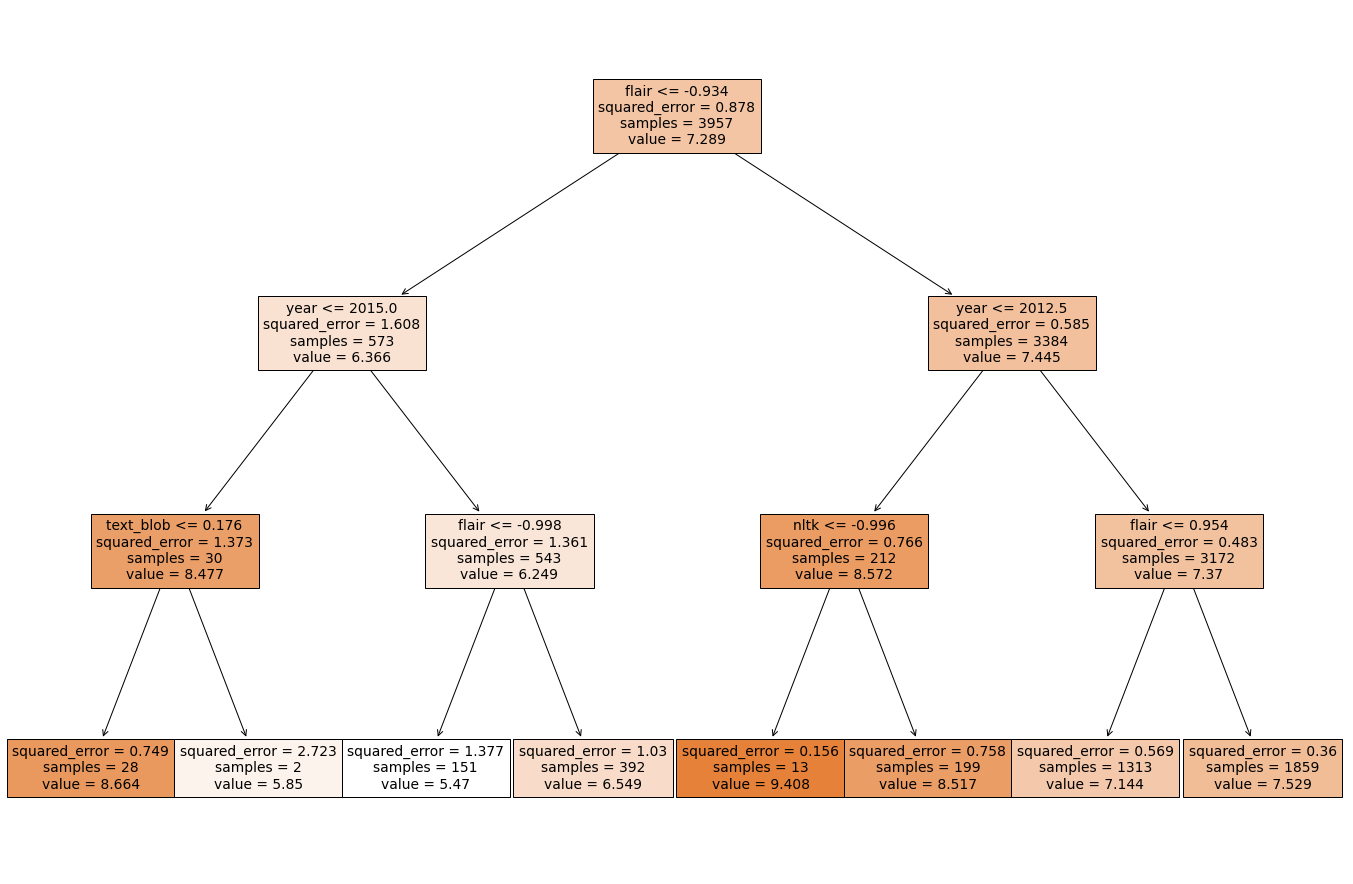

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(24,16))
plot_tree(tree_model, feature_names=X.columns, filled=True)

pass  # Avoid plot_tree to print text

### Florestas aleatórias

As florestas aleatórias combinam a simplicidade das árvores de regressão com uma maior flexibilidade, que reduz problemas de sobreajuste nos dados. Utilizando a mesma métrica aplicada anteriormente, foi possível reduzir o erro médio para 0,75. 

In [5]:
from sklearn.ensemble import RandomForestRegressor

rfce_model = RandomForestRegressor(criterion = 'absolute_error', 
                                   random_state=42, 
                                   n_estimators=100, 
                                   max_depth=5)
rfce_model.fit(X_train, y_train)

rfce_y_pred = rfce_model.predict(X_test)
rfce_mse = mean_squared_error(y_test, rfce_y_pred, squared=False)

rfce_mse

0.7525377128666417

### XGBoost

XGBoost apresenta um funcionamento similar às florestas aleatórias, porém cada árvore é desenvolvida a partir dos pontos fracos da árvore anterior, assim resultando em um modelo mais robusto. Com essa abordagem, foi possível diminuir o erro obtido para 0,74.

In [6]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                          colsample_bytree=0.3, 
                          learning_rate=0.1, 
                          max_depth=4, 
                          alpha=10, 
                          n_estimators=100)

xg_reg.fit(X_train, y_train)

xg_y_pred = xg_reg.predict(X_test)

xg_mse = mean_squared_error(y_test, xg_y_pred, squared=False)

xg_mse

0.7498716031582265

## Avaliação do modelo

Como o XGBoost apresentou o melhor resultado entre os modelos testado, este foi escolhido para realizar uma avaliação mais aprofundada da capacidade de predição e generalização do modelo.

Para isso, vamos primeiro carregar os dados como objetos `DMatrix`, que são melhor utilizados pela biblioteca do XGBoost. Vamos também definir seus parâmetros padrão para o treinamento. Aqui vamos também utilizar o método `train` invés de `fit` para o treinamento do modelo.

In [7]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 4,
    'min_child_weight': 1,
    'eta': 0.1,
    'subsample': 1,
    'colsample_bytree': 0.3,
    'objective': 'reg:squarederror',
    'eval_metric': "rmse",
    'alpha': 10
}

num_boost_round = 999

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:6.21412
[1]	Test-rmse:5.60791
[2]	Test-rmse:5.06358
[3]	Test-rmse:4.57770
[4]	Test-rmse:4.14016
[5]	Test-rmse:3.74974
[6]	Test-rmse:3.39726
[7]	Test-rmse:3.08263
[8]	Test-rmse:2.80187
[9]	Test-rmse:2.54944
[10]	Test-rmse:2.32713
[11]	Test-rmse:2.12725
[12]	Test-rmse:1.95218
[13]	Test-rmse:1.79482
[14]	Test-rmse:1.65872
[15]	Test-rmse:1.53295
[16]	Test-rmse:1.42234
[17]	Test-rmse:1.32847
[18]	Test-rmse:1.24824
[19]	Test-rmse:1.17384
[20]	Test-rmse:1.11105
[21]	Test-rmse:1.05681
[22]	Test-rmse:1.01291
[23]	Test-rmse:0.97435
[24]	Test-rmse:0.93866
[25]	Test-rmse:0.91201
[26]	Test-rmse:0.88836
[27]	Test-rmse:0.86807
[28]	Test-rmse:0.85169
[29]	Test-rmse:0.83771
[30]	Test-rmse:0.82488
[31]	Test-rmse:0.81558
[32]	Test-rmse:0.80587
[33]	Test-rmse:0.79912
[34]	Test-rmse:0.79339
[35]	Test-rmse:0.78741
[36]	Test-rmse:0.78215
[37]	Test-rmse:0.77907
[38]	Test-rmse:0.77576
[39]	Test-rmse:0.77329
[40]	Test-rmse:0.77121
[41]	Test-rmse:0.76860
[42]	Test-rmse:0.76638
[43]	Test-rmse:0.7639

A célula abaixo aplica a validação cruzada para a avaliação do modelo, que varia os conjuntos de dados de treino e de teste para garantir que o modelo apresente um bom desempenho independente da distribuição dos dados. Para essa tarefa, são utilizados todos os dados disponíveis. Com isso, foi possível chegar a um erro médio de 0,739.

In [8]:
all_data = xgb.DMatrix(X, label=y)

cv_results = xgb.cv(
    params,
    all_data,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,6.190469,0.006391,6.190400,0.029834
1,5.585372,0.004762,5.585502,0.029468
2,5.041833,0.003886,5.042024,0.028322
3,4.553927,0.003311,4.553994,0.027291
4,4.115314,0.003237,4.116232,0.026963
...,...,...,...,...
135,0.702738,0.006458,0.739282,0.023188
136,0.702614,0.006393,0.739294,0.023168
137,0.702526,0.006360,0.739241,0.023125
138,0.702318,0.006306,0.739182,0.023108


As células abaixo aplicam uma otimização de hiperparâmetros através da técnica Grid Search. primeiro são testados em conjunto os melhores valores para os parâmetros da arquitetura das árvores, e em seguida são testado os melhores valores de parâmetros para subamostragem do conjunto de dados que é realizada em cada etapa de boosting.

In [9]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,12)
    for min_child_weight in range(1,8)
]

param_labels = ("max_depth", "min_child_weight")

def grid_search(params, gridsearch_params, data, num_boost_round, param_labels):
    param1_label, param2_label = param_labels
    min_rmse = float("Inf")
    best_params = tuple()

    for param1, param2 in gridsearch_params:
        print(f"CV with {param1_label}={param1}, {param2_label}={param2}")

        # Update our parameters
        params[param1_label] = param1
        params[param2_label] = param2

        # Run CV
        cv_results = xgb.cv(
            params,
            data,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics={'rmse'},
            early_stopping_rounds=10
        )

        # Update best MAE
        mean_rmse = cv_results['test-rmse-mean'].min()
        boost_rounds = cv_results['test-rmse-mean'].idxmin()

        print(f"\nRMSE {mean_rmse} for {boost_rounds} rounds")

        if mean_rmse < min_rmse:
            min_rmse = mean_rmse
            best_params = (param1, param2)

    print(f"Best params: {best_params[0]}, {best_params[1]}, RMSE: {min_rmse}")

grid_search(params, gridsearch_params, all_data, num_boost_round, param_labels)

CV with max_depth=3, min_child_weight=1

RMSE 0.7387881999999999 for 202 rounds
CV with max_depth=3, min_child_weight=2

RMSE 0.7391092 for 178 rounds
CV with max_depth=3, min_child_weight=3

RMSE 0.7392778 for 206 rounds
CV with max_depth=3, min_child_weight=4

RMSE 0.7389296000000001 for 242 rounds
CV with max_depth=3, min_child_weight=5

RMSE 0.7392336 for 201 rounds
CV with max_depth=3, min_child_weight=6

RMSE 0.7391048 for 221 rounds
CV with max_depth=3, min_child_weight=7

RMSE 0.7384232 for 201 rounds
CV with max_depth=4, min_child_weight=1

RMSE 0.7391555999999999 for 139 rounds
CV with max_depth=4, min_child_weight=2

RMSE 0.7392868 for 164 rounds
CV with max_depth=4, min_child_weight=3

RMSE 0.739418 for 184 rounds
CV with max_depth=4, min_child_weight=4

RMSE 0.7394136 for 180 rounds
CV with max_depth=4, min_child_weight=5

RMSE 0.7398436 for 178 rounds
CV with max_depth=4, min_child_weight=6

RMSE 0.7398008 for 167 rounds
CV with max_depth=4, min_child_weight=7

RMSE 0.739

Os melhores valores obtidos foram 3 para profundidade máxima da árvore, e 7 para o peso mínimo do vértice, com um erro médio de 0,7384.

In [13]:
params['max_depth'] = 3
params['min_child_weight'] = 7

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(2,11)]
]

param_labels = ("subsample", "colsample_bytree")

grid_search(params, gridsearch_params, all_data, num_boost_round, param_labels)

CV with subsample=0.7, colsample_bytree=0.2

RMSE 0.742443 for 222 rounds
CV with subsample=0.7, colsample_bytree=0.3

RMSE 0.7421186 for 135 rounds
CV with subsample=0.7, colsample_bytree=0.4

RMSE 0.7392088 for 208 rounds
CV with subsample=0.7, colsample_bytree=0.5

RMSE 0.7387971999999999 for 140 rounds
CV with subsample=0.7, colsample_bytree=0.6

RMSE 0.7394262 for 104 rounds
CV with subsample=0.7, colsample_bytree=0.7

RMSE 0.7381989999999999 for 105 rounds
CV with subsample=0.7, colsample_bytree=0.8

RMSE 0.7389486 for 91 rounds
CV with subsample=0.7, colsample_bytree=0.9

RMSE 0.7391479999999999 for 89 rounds
CV with subsample=0.7, colsample_bytree=1.0

RMSE 0.738169 for 89 rounds
CV with subsample=0.8, colsample_bytree=0.2

RMSE 0.7428986 for 231 rounds
CV with subsample=0.8, colsample_bytree=0.3

RMSE 0.7403464000000001 for 227 rounds
CV with subsample=0.8, colsample_bytree=0.4

RMSE 0.74021 for 207 rounds
CV with subsample=0.8, colsample_bytree=0.5

RMSE 0.7389146 for 127 rou

Para esse Grid Search, temos como melhor valores 0,9 para a fração de linhas da subamostragem, e 1,0 para a fração de colunas (que corresponde a todas as colunas disponíveis). Com isso, foi possível reduzir o erro para 0,7366.

### Avaliação final

Como avaliação final, o modelo foi treinado com os hiperparâmetros obtidos através do Grid Search. O erro obtido pela métrica `RMSE` foi 0,75 e pela métrica `MAE` foi de 0,56, que são maiores do que os erros obtidos anteriormente. Isso pode ser explicado pela diferença de metodologia entre a validação cruzada e o treinamento normal.

In [16]:
params['subsample'] = 0.9
params['colsample_bytree'] = 1.0
params["eval_metric"] = "rmse"

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:6.21238
[1]	Test-rmse:5.60741
[2]	Test-rmse:5.06406
[3]	Test-rmse:4.57752
[4]	Test-rmse:4.13837
[5]	Test-rmse:3.74469
[6]	Test-rmse:3.39038
[7]	Test-rmse:3.07564
[8]	Test-rmse:2.79296
[9]	Test-rmse:2.54042
[10]	Test-rmse:2.31673
[11]	Test-rmse:2.11516
[12]	Test-rmse:1.93903
[13]	Test-rmse:1.78143
[14]	Test-rmse:1.64192
[15]	Test-rmse:1.51896
[16]	Test-rmse:1.41061
[17]	Test-rmse:1.31630
[18]	Test-rmse:1.23375
[19]	Test-rmse:1.16278
[20]	Test-rmse:1.09959
[21]	Test-rmse:1.04757
[22]	Test-rmse:1.00235
[23]	Test-rmse:0.96341
[24]	Test-rmse:0.93103
[25]	Test-rmse:0.90270
[26]	Test-rmse:0.87944
[27]	Test-rmse:0.85982
[28]	Test-rmse:0.84378
[29]	Test-rmse:0.83036
[30]	Test-rmse:0.81967
[31]	Test-rmse:0.80970
[32]	Test-rmse:0.80148
[33]	Test-rmse:0.79433
[34]	Test-rmse:0.78923
[35]	Test-rmse:0.78425
[36]	Test-rmse:0.78032
[37]	Test-rmse:0.77586
[38]	Test-rmse:0.77267
[39]	Test-rmse:0.77076
[40]	Test-rmse:0.76829
[41]	Test-rmse:0.76588
[42]	Test-rmse:0.76407
[43]	Test-rmse:0.7627

In [17]:
params["eval_metric"] = "mae"

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:6.14525
[1]	Test-mae:5.53575
[2]	Test-mae:4.98723
[3]	Test-mae:4.49423
[4]	Test-mae:4.04904
[5]	Test-mae:3.64940
[6]	Test-mae:3.28986
[7]	Test-mae:2.96940
[8]	Test-mae:2.68125
[9]	Test-mae:2.42266
[10]	Test-mae:2.19223
[11]	Test-mae:1.98579
[12]	Test-mae:1.80282
[13]	Test-mae:1.63995
[14]	Test-mae:1.49500
[15]	Test-mae:1.36687
[16]	Test-mae:1.25476
[17]	Test-mae:1.15789
[18]	Test-mae:1.07270
[19]	Test-mae:0.99759
[20]	Test-mae:0.93202
[21]	Test-mae:0.87668
[22]	Test-mae:0.82900
[23]	Test-mae:0.78893
[24]	Test-mae:0.75570
[25]	Test-mae:0.72694
[26]	Test-mae:0.70239
[27]	Test-mae:0.68186
[28]	Test-mae:0.66514
[29]	Test-mae:0.65082
[30]	Test-mae:0.63912
[31]	Test-mae:0.62811
[32]	Test-mae:0.61862
[33]	Test-mae:0.61040
[34]	Test-mae:0.60444
[35]	Test-mae:0.59894
[36]	Test-mae:0.59450
[37]	Test-mae:0.58979
[38]	Test-mae:0.58607
[39]	Test-mae:0.58349
[40]	Test-mae:0.58073
[41]	Test-mae:0.57811
[42]	Test-mae:0.57620
[43]	Test-mae:0.57456
[44]	Test-mae:0.57336
[45]	Test-mae:0.5722

## Limitações do trabalho

Esse trabalho pode apresentar algumas limitações quanto aos resultados. Por exemplo, no site da Pitchfork, as críticas são escritas por apenas um avaliador, enquanto as notas são obtidas através da média das notas dadas por diferentes críticos. Portanto, existem casos em que o conteúdo da crítica diverge da nota atribuída ao disco. O site também já foi acusado de ser imprevísivel em suas resenhas, e de deliberadamente escrever críticas provocativas para atrair mais atenção.

## Conclusões

Esse trabalho apresentou um modelo de aprendizado de máquina que tinha como objetivo predizer a nota atribuída a um disco pelo site Pitchfork, utilizando o conteúdo de sua crítica e características do disco como atributos. Os dados forma obtidos através de scraping no site, e transformados através de uma engenharia de atributos. Foram também aplicados técnicas de análise de sentimento no conteúdo das resenhas para obter atributos relevantes para a predição. Como resultados, foi obtido um erro médio absoluto de 0,56, que se mostrou como um bom resultado, considerando que as notas variam entre 0 e 10.